In [1]:
# Comparison of SGD, GA, and Hybrid Models

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the paths to the result directories
sgd_results_dir = '../results/sgd_run_20241111_141927'
ga_results_dir = '../results/ga_run_20241111_152148'
hybrid_results_dir = '../results/hybrid_run_20241112_113541'

# Create a list of result directories for iteration
result_dirs = [
    {'name': 'SGD', 'dir': sgd_results_dir},
    {'name': 'GA', 'dir': ga_results_dir},
    {'name': 'Hybrid', 'dir': hybrid_results_dir}
]

### Load Evaluation Metrics

In [2]:
# Initialize a list to store evaluation metrics for each model
evaluation_metrics_list = []

for result in result_dirs:
    eval_metrics_path = os.path.join(result['dir'], 'evaluation_metrics.json')
    with open(eval_metrics_path, 'r') as f:
        eval_metrics = json.load(f)
    eval_metrics['Model'] = result['name']
    evaluation_metrics_list.append(eval_metrics)

# Create a DataFrame for easy comparison
evaluation_df = pd.DataFrame(evaluation_metrics_list)

# Reorder columns for clarity
evaluation_df = evaluation_df[[
    'Model',
    'test_r2_score',
    'test_mse',
    'test_mae',
    'validation_r2_score',
    'validation_mse',
    'validation_mae',
    'best_mse_ga',
    'best_generation_ga',
    'best_val_loss_sgd',
    'epochs_sgd'
]]

# Display the evaluation metrics
evaluation_df

,Model,test_r2_score,test_mse,test_mae,validation_r2_score,validation_mse,validation_mae,best_mse_ga,best_generation_ga,best_val_loss_sgd,epochs_sgd
0,SGD,0.986723,0.000715,0.019589,0.984295,0.000780,0.020577,NaN,NaN,NaN,NaN
1,GA,0.759763,0.012933,0.084479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hybrid,0.991105,0.000479,0.016443,0.988055,0.000593,0.018096,0.015399,100.0,0.000593,100.0


### Visualizing Evaluation Metrics

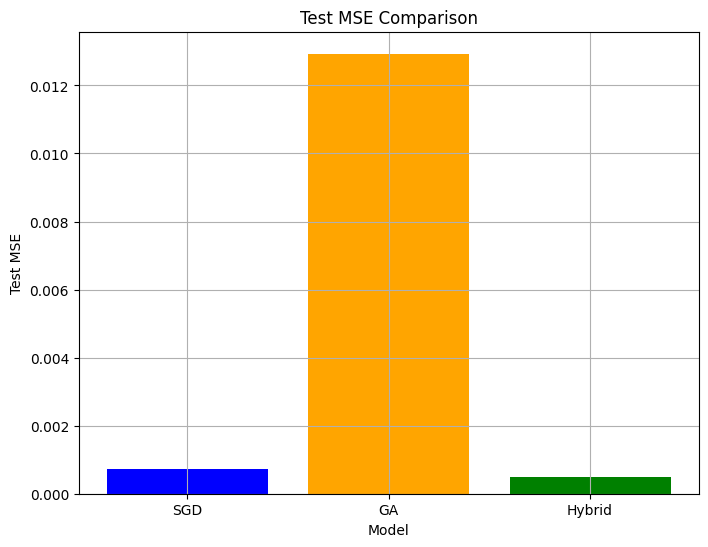

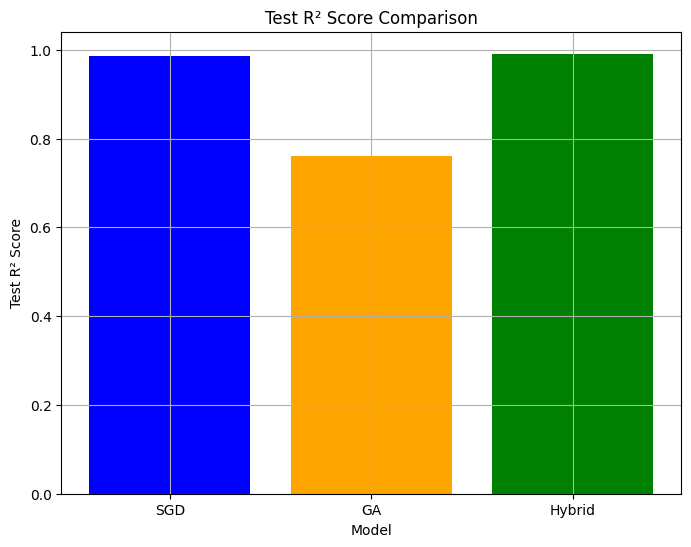

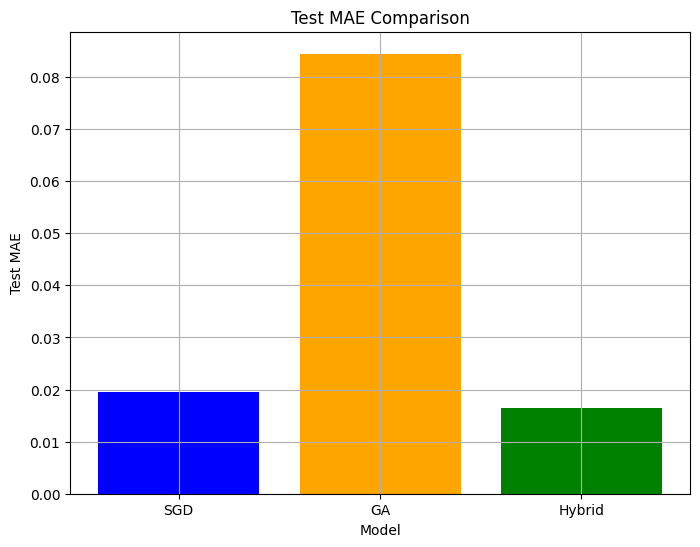

In [3]:
# Convert the necessary columns to numeric, ignoring errors due to NaN
evaluation_df_numeric = evaluation_df.copy()
for col in evaluation_df_numeric.columns:
    if col != 'Model':
        evaluation_df_numeric[col] = pd.to_numeric(evaluation_df_numeric[col], errors='coerce')

models = evaluation_df['Model']

# Plotting Test MSE for each model
plt.figure(figsize=(8, 6))
test_mse = evaluation_df_numeric['test_mse']
plt.bar(models, test_mse, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Test MSE')
plt.title('Test MSE Comparison')
plt.grid(True)
plt.show()

# Plotting Test R² Score for each model
plt.figure(figsize=(8, 6))
test_r2 = evaluation_df_numeric['test_r2_score']
plt.bar(models, test_r2, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Test R² Score')
plt.title('Test R² Score Comparison')
plt.grid(True)
plt.show()

# Plotting Test MAE for each model
plt.figure(figsize=(8, 6))
test_mae = evaluation_df_numeric['test_mae']
plt.bar(models, test_mae, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Test MAE')
plt.title('Test MAE Comparison')
plt.grid(True)
plt.show()

### Load Training Histories

In [4]:
# Initialize dictionaries to store training histories
training_histories = {}

for result in result_dirs:
    model_name = result['name']
    training_histories[model_name] = {}
    
    if model_name == 'GA':
        # Load GA training history
        ga_history_path = os.path.join(result['dir'], 'ga_training_history.json')
        with open(ga_history_path, 'r') as f:
            ga_history = json.load(f)
        training_histories[model_name] = ga_history
    elif model_name == 'SGD':
        # Load SGD training history
        sgd_history_path = os.path.join(result['dir'], 'training_history.json')
        with open(sgd_history_path, 'r') as f:
            sgd_history = json.load(f)
        training_histories[model_name] = sgd_history
    elif model_name == 'Hybrid':
        # Load both GA and SGD histories
        ga_history_path = os.path.join(result['dir'], 'ga_training_history.json')
        sgd_history_path = os.path.join(result['dir'], 'sgd_training_history.json')
        with open(ga_history_path, 'r') as f:
            ga_history = json.load(f)
        with open(sgd_history_path, 'r') as f:
            sgd_history = json.load(f)
        training_histories[model_name]['GA'] = ga_history
        training_histories[model_name]['SGD'] = sgd_history

### Plot Training Histories

SGD Training History Keys: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


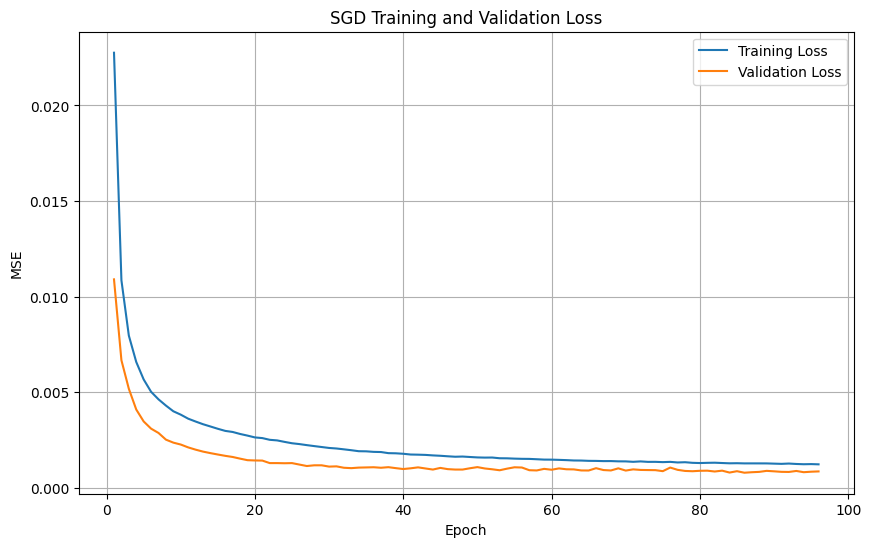

In [5]:
# Plot SGD Training History
sgd_history = training_histories['SGD']

# Check available keys in sgd_history
print("SGD Training History Keys:", sgd_history.keys())

# Depending on the structure, adjust how we access 'loss' and 'val_loss'
if 'loss' in sgd_history and 'val_loss' in sgd_history:
    epochs = range(1, len(sgd_history['loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, sgd_history['loss'], label='Training Loss')
    plt.plot(epochs, sgd_history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('SGD Training and Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
elif 'mse' in sgd_history and 'val_mse' in sgd_history:
    epochs = range(1, len(sgd_history['mse']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, sgd_history['mse'], label='Training MSE')
    plt.plot(epochs, sgd_history['val_mse'], label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('SGD Training and Validation MSE')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("SGD training history does not contain 'loss'/'val_loss' or 'mse'/'val_mse' keys.")
    print("Available keys:", sgd_history.keys())

GA Training History Keys: dict_keys(['best_mse', 'mean_mse', 'std_mse'])


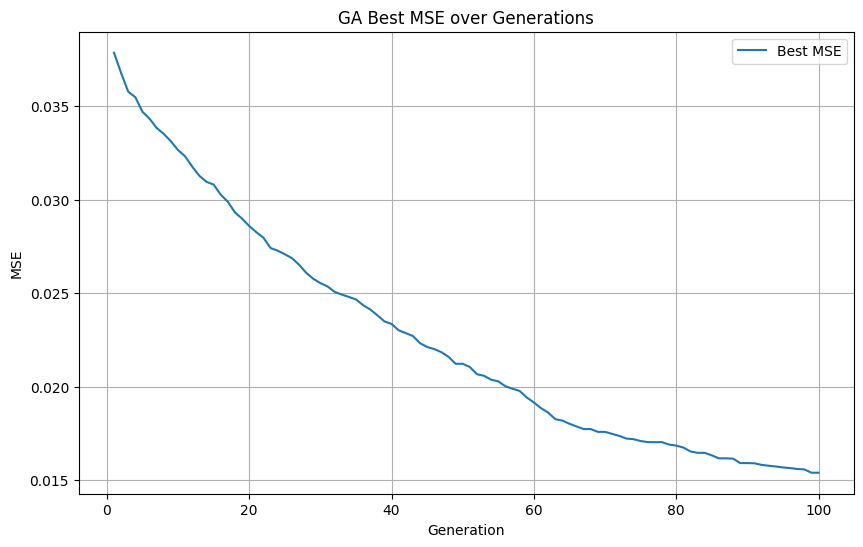

In [6]:
# Plot GA Training History
ga_history = training_histories['GA']

# Check available keys in ga_history
print("GA Training History Keys:", ga_history.keys())

if 'best_mse' in ga_history:
    generations = range(1, len(ga_history['best_mse']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(generations, ga_history['best_mse'], label='Best MSE')
    plt.xlabel('Generation')
    plt.ylabel('MSE')
    plt.title('GA Best MSE over Generations')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("GA training history does not contain 'best_mse' key.")
    print("Available keys:", ga_history.keys())


Hybrid GA History Keys: dict_keys(['best_mse', 'mean_mse', 'std_mse'])
Hybrid SGD History Keys: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


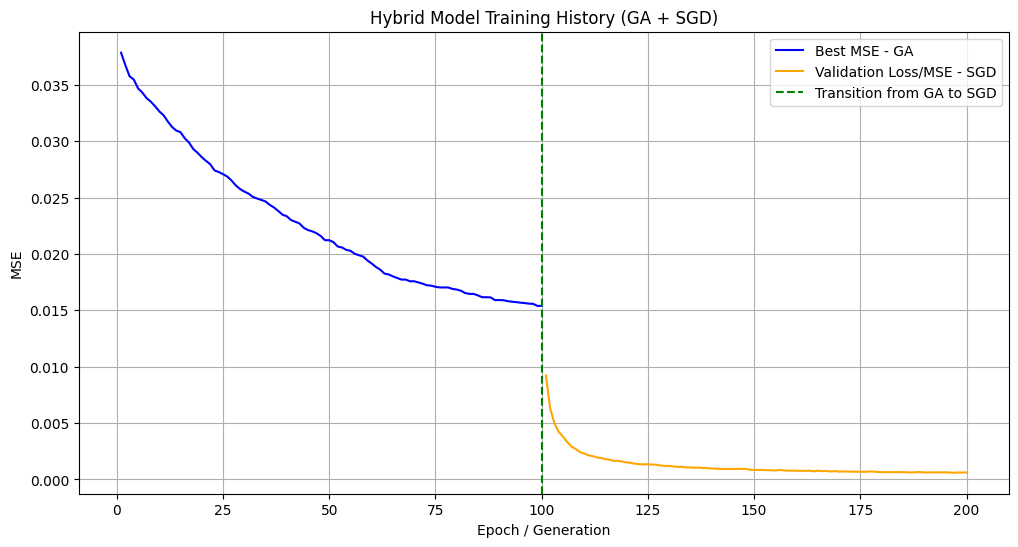

In [7]:
# Plot Hybrid Model Training History

# Check if both GA and SGD histories are available
if 'GA' in training_histories['Hybrid'] and 'SGD' in training_histories['Hybrid']:
    # GA Part
    hybrid_ga_history = training_histories['Hybrid']['GA']
    # SGD Part
    hybrid_sgd_history = training_histories['Hybrid']['SGD']

    # Check available keys
    print("Hybrid GA History Keys:", hybrid_ga_history.keys())
    print("Hybrid SGD History Keys:", hybrid_sgd_history.keys())

    if 'best_mse' in hybrid_ga_history:
        ga_generations = range(1, len(hybrid_ga_history['best_mse']) + 1)
    else:
        print("Hybrid GA history does not contain 'best_mse' key.")
        ga_generations = []

    if 'loss' in hybrid_sgd_history and 'val_loss' in hybrid_sgd_history:
        sgd_epochs = range(len(ga_generations) + 1, len(ga_generations) + len(hybrid_sgd_history['loss']) + 1)
        sgd_val_loss = hybrid_sgd_history['val_loss']
    elif 'mse' in hybrid_sgd_history and 'val_mse' in hybrid_sgd_history:
        sgd_epochs = range(len(ga_generations) + 1, len(ga_generations) + len(hybrid_sgd_history['mse']) + 1)
        sgd_val_loss = hybrid_sgd_history['val_mse']
    else:
        print("Hybrid SGD history does not contain expected keys.")
        sgd_epochs = []
        sgd_val_loss = []

    # Combine GA and SGD histories for Hybrid
    combined_mse = hybrid_ga_history.get('best_mse', []) + sgd_val_loss
    combined_epochs = range(1, len(combined_mse) + 1)

    plt.figure(figsize=(12, 6))
    if ga_generations:
        plt.plot(ga_generations, hybrid_ga_history['best_mse'], label='Best MSE - GA', color='blue')
    if sgd_epochs:
        plt.plot(sgd_epochs, sgd_val_loss, label='Validation Loss/MSE - SGD', color='orange')
    plt.xlabel('Epoch / Generation')
    plt.ylabel('MSE')
    plt.title('Hybrid Model Training History (GA + SGD)')
    if ga_generations and sgd_epochs:
        plt.axvline(x=len(ga_generations), color='green', linestyle='--', label='Transition from GA to SGD')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Hybrid training history does not contain both 'GA' and 'SGD' keys.")

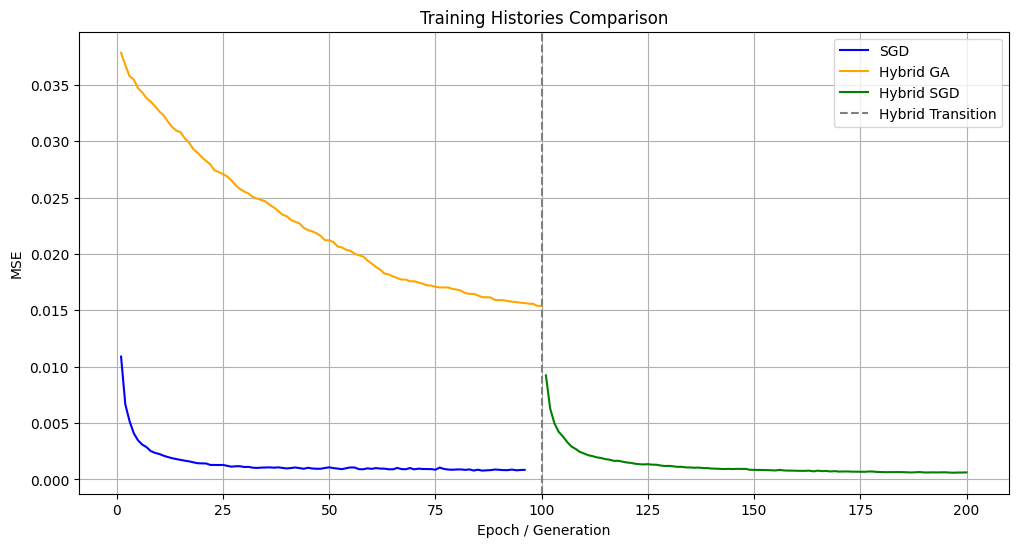

In [8]:
# Plot Combined Training Histories for All Models

plt.figure(figsize=(12, 6))

# SGD Model
sgd_history = training_histories['SGD']
if 'val_loss' in sgd_history:
    sgd_epochs = range(1, len(sgd_history['val_loss']) + 1)
    plt.plot(sgd_epochs, sgd_history['val_loss'], label='SGD', color='blue')
elif 'val_mse' in sgd_history:
    sgd_epochs = range(1, len(sgd_history['val_mse']) + 1)
    plt.plot(sgd_epochs, sgd_history['val_mse'], label='SGD', color='blue')
else:
    print("SGD history does not contain 'val_loss' or 'val_mse' key. Available keys:", sgd_history.keys())

# Hybrid Model
hybrid_history = training_histories['Hybrid']
if 'GA' in hybrid_history and 'SGD' in hybrid_history:
    hybrid_ga_history = hybrid_history['GA']
    hybrid_sgd_history = hybrid_history['SGD']
    if 'best_mse' in hybrid_ga_history:
        hybrid_ga_generations = range(1, len(hybrid_ga_history['best_mse']) + 1)
        hybrid_ga_mse = hybrid_ga_history['best_mse']
    else:
        print("Hybrid GA history does not contain 'best_mse' key.")
        hybrid_ga_generations = []
        hybrid_ga_mse = []

    if 'val_loss' in hybrid_sgd_history:
        hybrid_sgd_epochs = range(len(hybrid_ga_generations) + 1, len(hybrid_ga_generations) + len(hybrid_sgd_history['val_loss']) + 1)
        hybrid_sgd_mse = hybrid_sgd_history['val_loss']
    elif 'val_mse' in hybrid_sgd_history:
        hybrid_sgd_epochs = range(len(hybrid_ga_generations) + 1, len(hybrid_ga_generations) + len(hybrid_sgd_history['val_mse']) + 1)
        hybrid_sgd_mse = hybrid_sgd_history['val_mse']
    else:
        print("Hybrid SGD history does not contain expected keys.")
        hybrid_sgd_epochs = []
        hybrid_sgd_mse = []

    # Plot the GA part of the Hybrid model in orange
    if hybrid_ga_generations:
        plt.plot(hybrid_ga_generations, hybrid_ga_mse, label='Hybrid GA', color='orange')
    # Plot the SGD part of the Hybrid model in green
    if hybrid_sgd_epochs:
        plt.plot(hybrid_sgd_epochs, hybrid_sgd_mse, label='Hybrid SGD', color='green')
    # Add a vertical line to indicate the transition point
    if hybrid_ga_generations and hybrid_sgd_epochs:
        plt.axvline(x=len(hybrid_ga_generations), color='gray', linestyle='--', label='Hybrid Transition')
else:
    print("Hybrid history does not contain both 'GA' and 'SGD' keys.")

plt.xlabel('Epoch / Generation')
plt.ylabel('MSE')
plt.title('Training Histories Comparison')
plt.grid(True)
plt.legend()
plt.show()